In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Logistic vs. Linear Regression

__Linear regression:__ predict a continuous outcome variable $y$, ie how much money a customer will spend
- Formula for multivariate linear regr relating outcome $y$ to matrix of variables $X$:
$$y=\alpha + \beta X$$

__Logistic regression:__ predict the probability of a categorical outcome (using regression as a classifier)
- Formula for binary logistic regr relating $p$ to a matrix of variables $X$:

$$ln\left(\dfrac p{1-p}\right)=\beta X$$

- $p=$ the probability of $y=1$

- $1-p=$ the probability of $y=0$

- The ratio of $p$ to $1-p$ gives the odds of getting $y=1$

__Example:__ what are the odds for an unfair coin with an 80% probability of heads

- heads = .8/(1-.8) = 4, ie you are 4 times more likely to get heads than tails
- tails = .2/(1-.2) = .25

__Assumptions of logistic regr:__ same assumptions as linear regression
- Linearity of the transformed probabilities and the predictors
- Multivariate normality of the residuals
- Homoscedasticity (variance of residuals is constant across predicted values)
- Low multicollinearity

__Why log?:__ binary outcome (0,1) converted into logged odds because regression requires normally distributed residuals

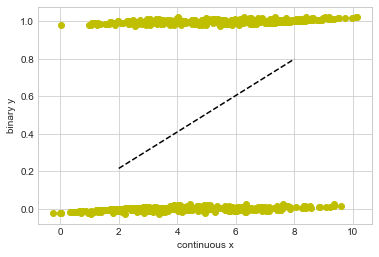

In [5]:
sns.set_style('whitegrid')
#set random seed so results are the same each time code is run
np.random.seed(seed=456613)

#create data
df = pd.DataFrame()
for probs in list(range(2,9)):
    tmp = pd.DataFrame({
        'y': np.random.binomial(1, probs/10, size=(1,100))[0],
        'x': probs
    })
    df = df.append(tmp)
    
x = df['x'] #continuous predictor
bin_y = df['y'] #binary outcome

#calculate linear regression for bot x and bin_y
fit = np.polyfit(x,bin_y,1)

#work as a function to return the predicted value of y
fit_fn = np.poly1d(fit)

#add some noise for graphing purposes
jitter = np.random.randn(700)

#display results
plt.plot(x + jitter, bin_y + jitter / 100, 'yo', x, fit_fn(x), '--k')
plt.xlabel('continuous x')
plt.ylabel('binary y')
plt.show()

Because y only takes two outcomes, relationship between x and y is very non linear. A regression line would fit very poorly to this data.